# Film Success in China - Modeling and Analysis
Metis Project 2  
(File 2 of 2)  
October 12, 2020  
Amanda Cheney  

**Objective**  
Build a regression model to explain the success of films in the Chinese market. 

**Sources**  
Chinese box office data on over 1,100 films released in China in the years 2016-2019 scraped from [Box Office Mojo](https://www.boxofficemojo.com/weekend/by-year/2019/?area=CN) and supplemented by the [IMDb movies extensive](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv) dataset on Kaggle.

In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

#### Testing Linear Assumptions

Preliminary EDA and pairplot did not indicate that my target variable, `PRC_rev`, has a non-linear relationship with any of my features. Therefore my initial model is poised to meet the first assumption of OLS. However, when I check to confirm the second assumption, i.e. that the residuals (error values, $\epsilon_i$) are normally distributed about $\epsilon = 0$, I find that my model fails. This is likely because `PRC_rev` is extremely right skewed. Therefore I will use the log transformation of this as my new target variable `PRC_rev_log` which does meet the second assumption.  However, `PRC_rev_log` now has a non-linear relationship with `USA_rev` so I also perform a log transformation of this feature. None of my other features looks have strong multi-colinearity so I do not perform any additional feature transformation.

In [2]:
with open('combined.pickle', 'rb') as read_file:
    combined = pickle.load(read_file)

In [3]:
combined.shape

(1086, 36)

In [4]:
X = combined[[ 'USA_rev','PRC_only', 'runtime',
       'release_period', 'release_month',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'ch_film']]
y = combined['PRC_rev']

In [5]:
lr = LinearRegression()
fit = lr.fit(X, y)

combined['predict'] = fit.predict(X)
combined['resid'] = combined.predict - combined['PRC_rev']

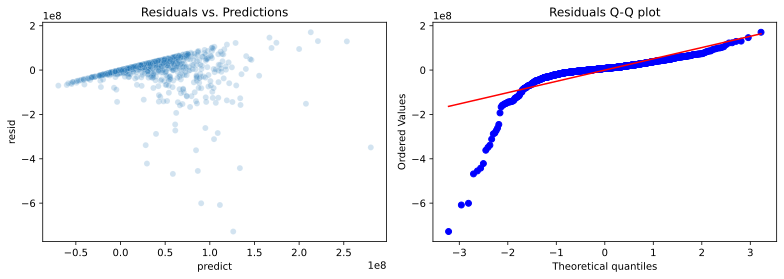

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

sns.scatterplot(data=combined, x='predict', y='resid', alpha=0.2, ax=axes[0])
stats.probplot(combined['resid'], dist="norm", plot=axes[1])

axes[0].set_title("Residuals vs. Predictions")
axes[1].set_title("Residuals Q-Q plot")

plt.tight_layout()

In [7]:
combined['PRC_rev_log'] = np.log(combined.PRC_rev)

In [8]:
y = combined.PRC_rev_log
lr = LinearRegression()
fit = lr.fit(X, y)

combined['predict'] = fit.predict(X)
combined['resid'] = combined.predict - combined['PRC_rev_log']

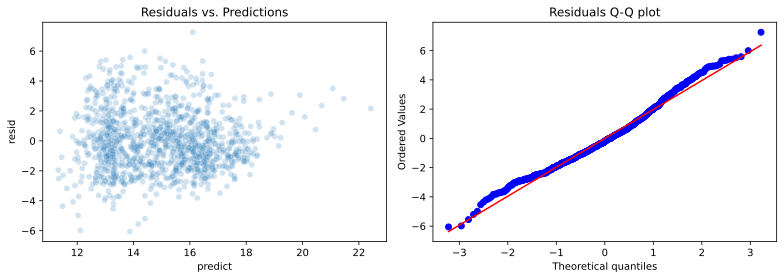

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

sns.scatterplot(data=combined, x='predict', y='resid', alpha=0.2, ax=axes[0])
stats.probplot(combined['resid'], dist="norm", plot=axes[1])

axes[0].set_title("Residuals vs. Predictions")
axes[1].set_title("Residuals Q-Q plot")

plt.tight_layout()

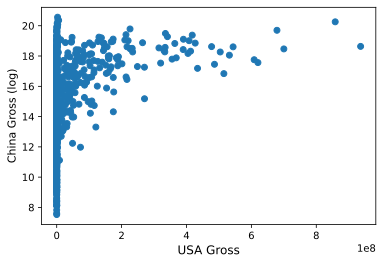

In [10]:
plt.scatter(combined.USA_rev, combined.PRC_rev_log)
plt.xlabel('USA Gross', fontsize=12)
plt.ylabel('China Gross (log)', fontsize=11);

In [11]:
combined['USA_rev_log'] = np.log(combined['USA_rev'].replace(0, 0.001))

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


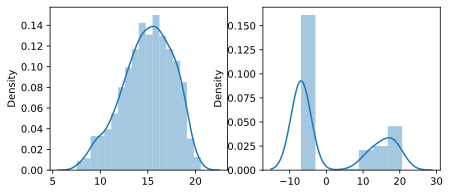

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
sns.distplot(x=combined['PRC_rev_log'], ax=ax1)
sns.distplot(x=combined['USA_rev_log'], ax=ax2);

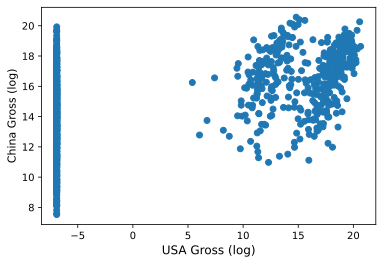

In [13]:
plt.scatter(combined.USA_rev_log, combined.PRC_rev_log); # this graph is still weird.
plt.xlabel('USA Gross (log)', fontsize=12)
plt.ylabel('China Gross (log)', fontsize=11);

In [14]:
combined.drop(['USA_rev', 'PRC_rev', 'predict', 'resid'], axis=1, inplace=True)
combined = combined[['title_x', 'PRC_only', 'runtime', 'release_period', 'release_month',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'ch_film', 'USA_rev_log','PRC_rev_log', ]]

Checking for multi-colinearity. None of my other features looks have strong multi-colinearity so I do not perform any additional feature transformation.

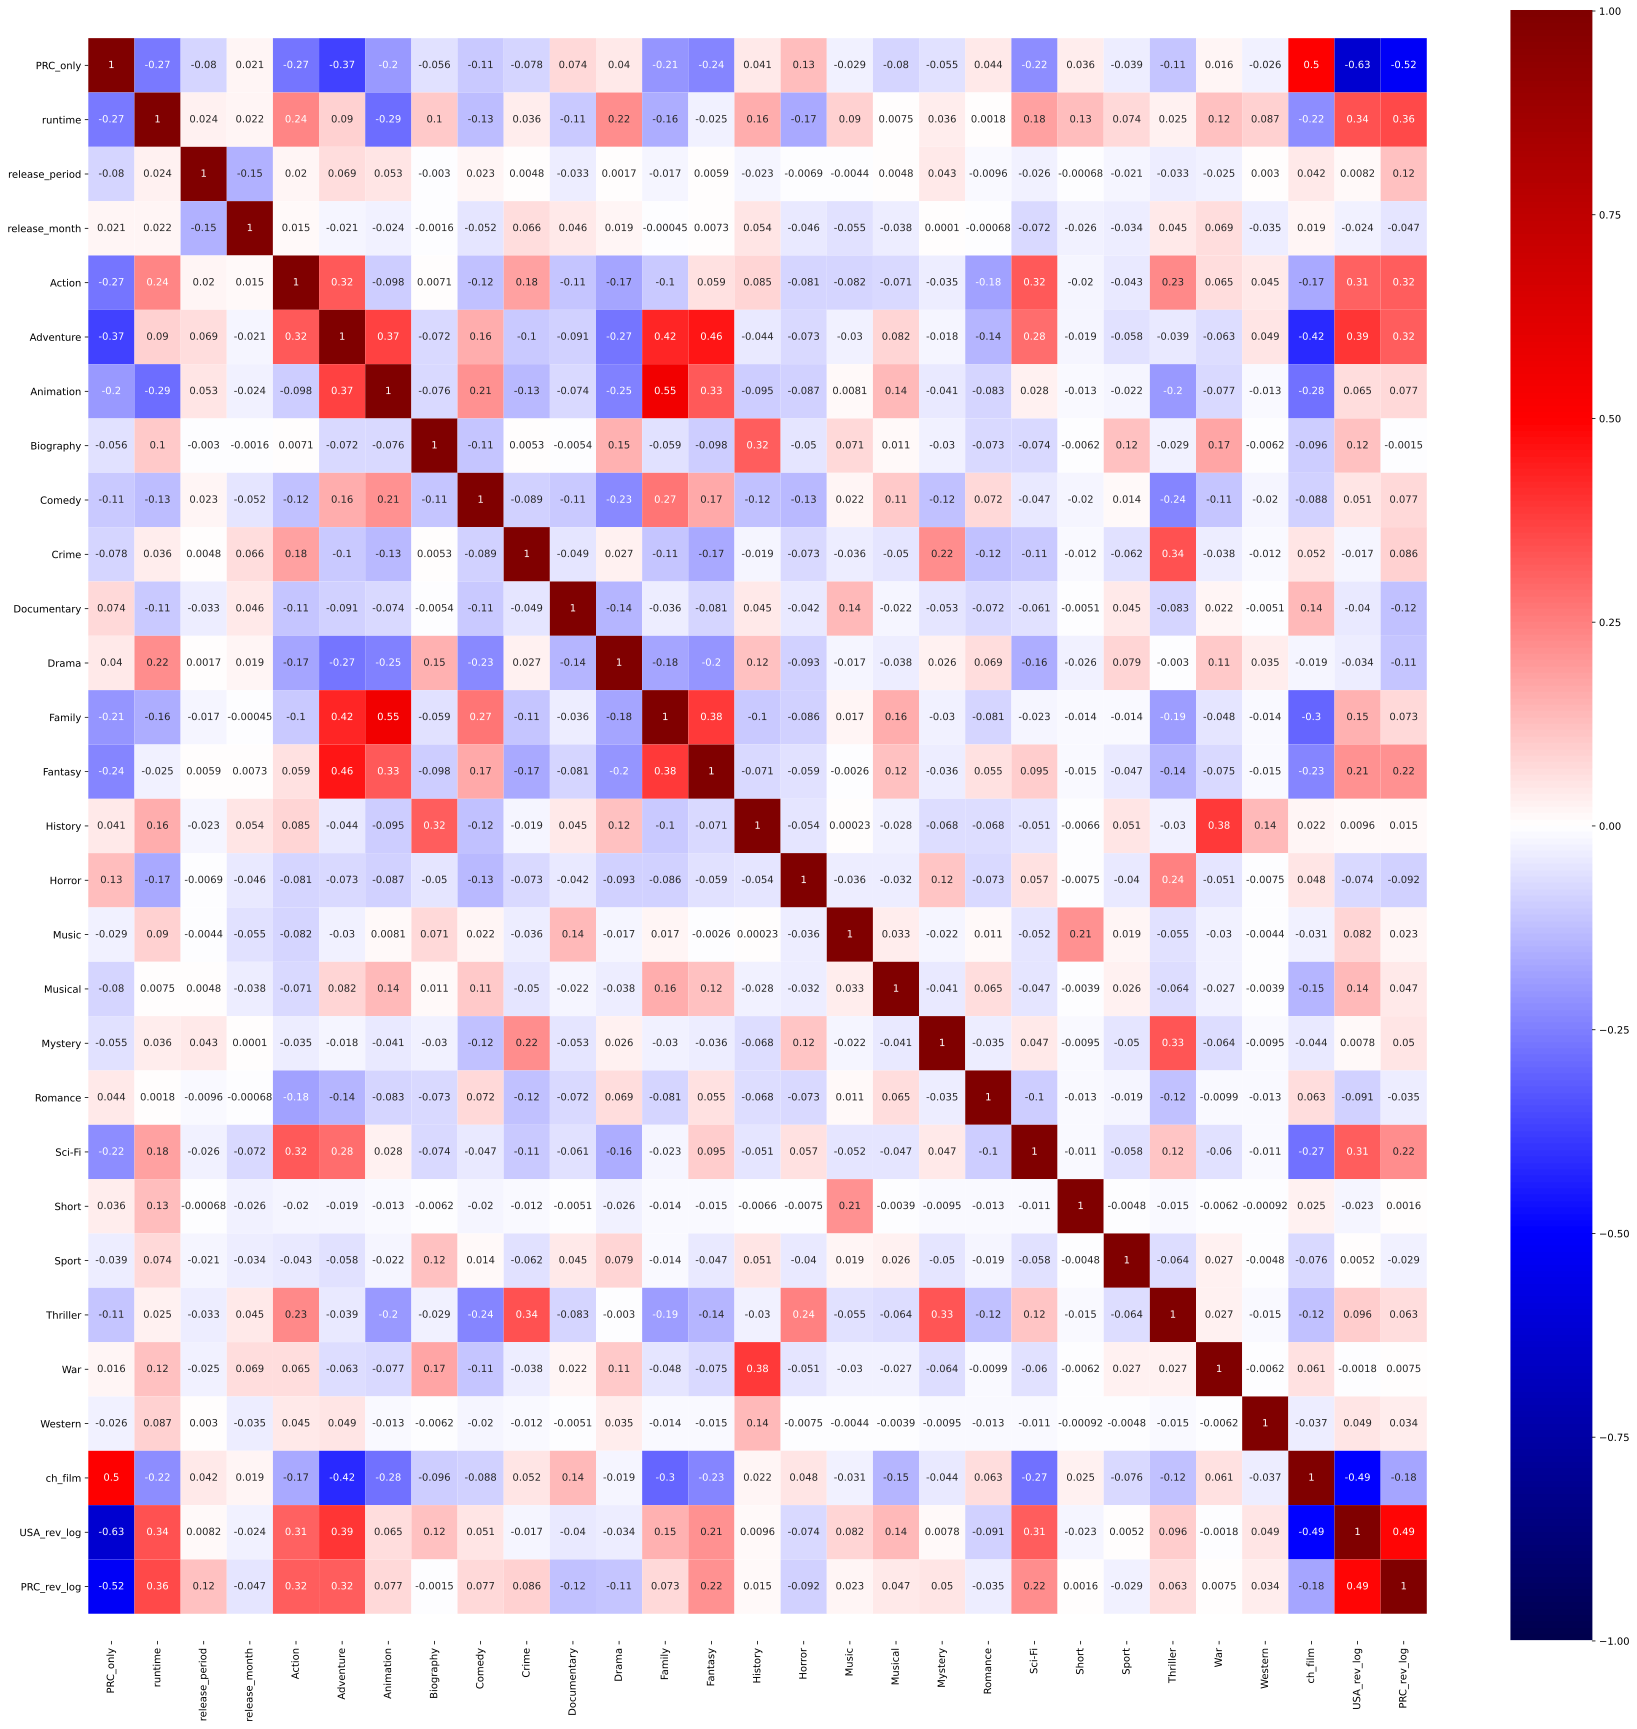

In [15]:
plt.figure(figsize = [30,30])
sns.heatmap(combined.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

plt.gca().set_ylim(len(combined.corr())+0.5, -0.5);

Now to further refine my features. Start by getting rid of anything with less than .05 correlation with target. 

In [16]:
combined.corr()['PRC_rev_log'].sort_values(ascending=False)

PRC_rev_log       1.000000
USA_rev_log       0.490975
runtime           0.356925
Adventure         0.318747
Action            0.315939
Sci-Fi            0.219138
Fantasy           0.215583
release_period    0.123214
Crime             0.086143
Comedy            0.077167
Animation         0.076721
Family            0.072781
Thriller          0.063191
Mystery           0.050078
Musical           0.046855
Western           0.033555
Music             0.022988
History           0.014694
War               0.007455
Short             0.001619
Biography        -0.001487
Sport            -0.029203
Romance          -0.035035
release_month    -0.046979
Horror           -0.091578
Drama            -0.112229
Documentary      -0.122520
ch_film          -0.175876
PRC_only         -0.520215
Name: PRC_rev_log, dtype: float64

In [17]:
smaller_combined = combined[['USA_rev_log','PRC_only', 'runtime',
       'release_period',   'Action', 'Adventure', 'Animation',  'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Thriller', 'ch_film', 'PRC_rev_log']]

In [18]:
with open('smaller_combined.pickle', 'wb') as to_write:
    pickle.dump(smaller_combined, to_write)

In [19]:
y = smaller_combined['PRC_rev_log']
X = smaller_combined[['USA_rev_log','PRC_only', 'runtime',
       'release_period',   'Action', 'Adventure', 'Animation',  'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Thriller', 'ch_film']]

Now to compare various models. Start by splitting data into train, test and validate groups for validation.

In [20]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [21]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Linear Regression:\nValidation data R^2: {lm.score(X_val, y_val):.3f}')
print("Training data R^2:", lm.score(X_train, y_train))

Linear Regression:
Validation data R^2: 0.455
Training data R^2: 0.44044006221671483


In [22]:
#Feature scaling for train, val, and test so that we can run lasso model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [23]:
alphavec = 10**np.linspace(-10,10,200) #larger values will tell lasso how aggressively to reduce features 
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        cv=5)

In [24]:
lasso_model.alpha_

0.010969857978923863

In [25]:
lassoCV_model = LassoCV()
lassoCV_model.fit(X_train_scaled, y_train)
lassoCV_model.score(X_val_scaled, y_val)
lassoCV_model.score(X_train_scaled, y_train)

0.44008114334845727

Training and test scores are basically the same, this suggests a good fit.

In [26]:
lr_model_lasso = Lasso(alpha = 0.01)
lr_model_lasso.fit(X_train_scaled, y_train)
lr_model_lasso.score(X_val_scaled, y_val), lr_model_lasso.score(X_train_scaled, y_train)

(0.4552366921144495, 0.4402166269190825)

Training and test scores are basically the same, this suggests a good fit.

In [27]:
list(zip(X_train, lr_model_lasso.coef_))

[('USA_rev_log', 0.6580111062994707),
 ('PRC_only', -0.7781783873868369),
 ('runtime', 0.717520352631733),
 ('release_period', 0.2732772829861075),
 ('Action', 0.17019070616983134),
 ('Adventure', 0.10610046184581329),
 ('Animation', 0.23184008565488795),
 ('Comedy', 0.148068675682926),
 ('Crime', 0.1615572185015325),
 ('Documentary', -0.14492519407088145),
 ('Drama', -0.17659434426164802),
 ('Fantasy', 0.19503263671983215),
 ('Thriller', 0.04792437390000472),
 ('ch_film', 0.538819535103351)]

In [28]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [29]:
test_set_pred = lassoCV_model.predict(X_test_scaled)
print("Lasso CV MAE:", mae(y_test, test_set_pred))
print("Lasso CV r^2", r2_score(y_test, test_set_pred))

Lasso CV MAE: 1.6061729912692841
Lasso CV r^2 0.3611292982002835


In [30]:
test_set_pred = lm.predict(X_test)
print("Regular Linear Regression MAE:", mae(y_test, test_set_pred))
print("Regular Linear Regression:", r2_score(y_test, test_set_pred))

Regular Linear Regression MAE: 1.603740506804417
Regular Linear Regression: 0.3600325364449919


So far initial cross validation shows regular linear regression to be performing nearly as well as LassoCV. However let's run k-fold cross validation to see if one doesn't outperform the other. 

In [31]:
from sklearn.model_selection import cross_val_score
# lm = LinearRegression()

print("Kfold cross validation scores on regular linear regression model:", cross_val_score(lm, X_val, y_val, cv=5, scoring='r2')) 

Kfold cross validation scores on regular linear regression model: [-0.01822218  0.31087612  0.49438294  0.49724255  0.46224118]


In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print("Kfold cross validation scores on lasso model:", cross_val_score(lasso_model, X_val_scaled, y_val, cv=kf, scoring='r2'))

Kfold cross validation scores on lasso model: [0.09806494 0.40770841 0.55025645 0.45272344 0.1434887 ]


In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print("Average Kfold cross validation scores on lasso model (val data):", np.mean(cross_val_score(lasso_model, X_val_scaled, y_val, cv=kf, scoring='r2')))
print("Average Kfold cross validation scores on linear regression model (val data):", np.mean(cross_val_score(lm, X_val, y_val, cv=kf, scoring='r2')))

Average Kfold cross validation scores on lasso model (val data): 0.32220044248927654
Average Kfold cross validation scores on linear regression model (val data): 0.2989051491681467


The marginally higher Kfold score for Lasso suggests that Lasso model is superior to regular linear regression. So I will continue with a Lasso model.
But first it is necessary to re-fit model using combined `train` and `val` data before testing on the holdout `test` data. 

In [34]:
refitting_x=pd.concat([X_train, X_val])
refitting_y=pd.concat([y_train, y_val])

In [35]:
scaler = StandardScaler()
X_refitting_scaled = scaler.fit_transform(refitting_x.values)

In [36]:
lr_model_lasso.fit(X_refitting_scaled, refitting_y)
lr_model_lasso.score(X_test_scaled, y_test)

0.3729181185853304

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print("Final score for Lasso Model (test data):", np.mean(cross_val_score(lr_model_lasso, X_test_scaled, y_test, cv=kf, scoring='r2')))
print("Final score for linear regression (test data):", np.mean(cross_val_score(lm, X_test, y_test, cv=kf, scoring='r2')))

Final score for Lasso Model (test data): 0.2992816881679966
Final score for linear regression (test data): 0.294328837059996


In [38]:
list(zip(X_test, lr_model_lasso.coef_))

[('USA_rev_log', 0.6708151315911075),
 ('PRC_only', -0.8259320295593331),
 ('runtime', 0.6828157295771162),
 ('release_period', 0.17937091412689996),
 ('Action', 0.21296219945834818),
 ('Adventure', 0.12602170008070981),
 ('Animation', 0.22045946967549895),
 ('Comedy', 0.09877755150028629),
 ('Crime', 0.143949099484749),
 ('Documentary', -0.16734689557237828),
 ('Drama', -0.1912472775678581),
 ('Fantasy', 0.19470904816189313),
 ('Thriller', 0.04781913584683074),
 ('ch_film', 0.6024278166999976)]

In [39]:
smaller_combined = smaller_combined.rename(columns={'USA_rev_log': "US Gross (log)", 'PRC_only': "Released Only in China", 'release_period': "Length of release", 'release_month': "Month of release",
'ch_film': 'Chinese Production', 'runtime': 'Runtime', 'PRC_rev_log': "China Gross (log)"})

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


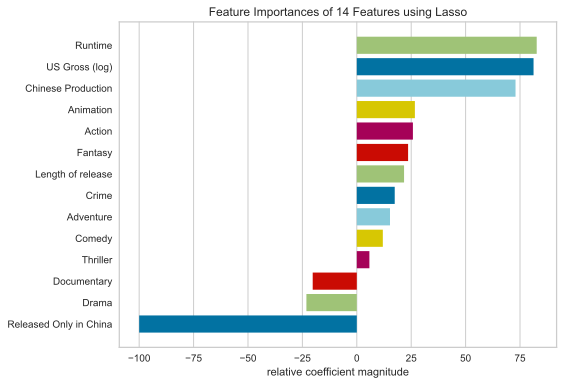

In [40]:
from yellowbrick.model_selection import FeatureImportances

labels = list(map(lambda s: s, smaller_combined[['US Gross (log)', 'Released Only in China', 'Runtime', 'Length of release',
        'Action', 'Adventure', 'Animation', 
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
        'Thriller', 'Chinese Production']]))

viz = FeatureImportances(lr_model_lasso, labels=labels)
viz.fit(X_refitting_scaled, y_train)
viz.show(outpath="feature_importances.pdf");